In [1]:
from __future__ import division

from pylab import *
import scipy
import time
import utils
import hrr_utils
import RM_utils
import utilities.colormaps as colormaps
import random
import string
import csv

#import imnet_utils as imut
import sklearn
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF
from scipy import stats

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.family': 'serif', 'font.serif':['Computer Modern']})


In [3]:
alph = 'abcdefghijklmnopqrstuvwxyz#.'
xticks = [k for k in range(0, len(alph), 3)]
xticklabels = [alph[i] for i in range(0, len(alph), 3)]
D = len(alph)

with open('data/8-letter-words.csv') as f:
    words8 = []
    for row in csv.reader(f, delimiter=',', quoting=csv.QUOTE_NONE):
        words8 += row

with open('data/4-letter-words.csv') as f:
    words4 = []
    for row in csv.reader(f, delimiter=',', quoting=csv.QUOTE_NONE):
        words4 += row

In [4]:
def ngram_encode(ngram_str, letter_vecs, alph):
    vec = np.zeros(letter_vecs.shape[1])
    
    full_str = '#' + ngram_str + '.'
    
    
    for il, l in enumerate(full_str[:-2]):
        trivec = letter_vecs[alph.find(full_str[il]), :]
        for c3 in range(1, 3):
            trivec = trivec * np.roll(letter_vecs[alph.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return vec

def ngram_encode_cl(ngram_str, letter_vecs, alph):
    vec = ngram_encode(ngram_str, letter_vecs, alph)
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) > 0) - 1

def sim(x, y):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)

def initialize(letter_vecs, N, D, state_length=5, n_steps=500):
    states = []
    coef_hists = []
    
    for i in range(state_length):
        states.append(np.random.randn(N))
    
    for i in range(1, state_length-1):
        states[i] = np.dot(letter_vecs.T, np.dot(states[i], letter_vecs.T))

    for i in range(1, state_length-1):
        states[i] = states[i]/norm(states[i])

    states[0] = letter_vecs[alph.find('#'), :]
    states[state_length-1] = letter_vecs[alph.find('.'), :]
    
    for i in range(1, state_length-1):
        coef_hists.append(np.zeros((n_steps, D)))
    
    return states, coef_hists

def spell(coef_hists):
    pred = ''
    alphis = []

    for i in range(len(coef_hists)):
        x, alphi = np.unravel_index(coef_hists[i].argmax(), coef_hists[i].shape)
        pred += alph[alphi]
        alphis.append(alphi)

    return pred, alphis

def explain_away(bound_vec, states, coef_hists, state_length, letter_vecs, 
                 N, D, max_steps=500, conseq=100):
    th_vec = bound_vec.copy()
    conseq_preds = []
    convstep = -1

    for i in range(max_steps):

        for j in range(1, state_length-1):
            coef_hists[j-1][i, :] = np.dot(letter_vecs, states[j])
        
        for j in range(1, state_length-1):
            mxidx = np.argmax(np.abs(coef_hists[j-1][i,:]))
            states[j] *= np.sign(coef_hists[j-1][i, mxidx])
        ljds = []
        for j in range(1, state_length-1):
            if j == 1:
                ljds.append(
                    (np.roll(th_vec * states[0] * np.roll(states[2], 2), -1) +
                    th_vec * np.roll(states[2], 1) * np.roll(states[3], 2)) / 2
                )
            elif 1 < j < state_length-2:
                ljds.append(
                    (np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2) +
                    np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                      th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 3
                )
            else:
                ljds.append(
                    (np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                   np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2)) / 2
                )

        for j in range(1, state_length-1):    
            states[j] = np.dot(letter_vecs.T, np.dot(ljds[j-1], letter_vecs.T)/N) + 1.0*states[j]
        
        bv = states[0] * np.roll(states[1],1) * np.roll(states[2],2)  
        for j in range(1, state_length-2):
            bv += states[j] * np.roll(states[j+1],1) * np.roll(states[j+2],2) 
         
        th_vec = bound_vec - bv
        pred, alphis = spell(coef_hists)
        
        if convstep == -1:
            if len(conseq_preds) == conseq and len( set( conseq_preds ) ) == 1:
                convstep = i
                #break
            conseq_preds.append(pred)
            conseq_preds = conseq_preds[-conseq:]

#         print ('pred', pred)
#     print ('conseq', conseq_preds, len(conseq_preds))
#     print ('breaked', i, convstep)
    if convstep == -1:
        convstep=i
    return states, coef_hists, convstep
    
def resplot(word_length, states, coef_hists, N, nsteps, start):
    
    pred, alphis = spell(coef_hists)
    print pred
    rows = 1
    columns = word_length

    fig, axes = plt.subplots(rows, columns, sharex='all', squeeze=True, figsize=(6, 2.5))
    cols = get_cmap('copper', min(500,n_steps))
    x = np.linspace(0,len(alph)-2,len(alph)-2)
    labels = list(alph)
    plt.xticks(x, labels)
    
    
    
    for j in range(word_length):
        for i in range(start, min(500,n_steps)):
            # graphing the max positive at every iteration is not intuitive, since we should
            # be focusing on how our predicted letter's probability increases over time
            coef_hists[j][i,alphis[j]] = np.abs(coef_hists[j][i,alphis[j]])
            axes[j].plot(coef_hists[j][i,:], lw=1.7, c=cols(i))
            
        step, alphi = np.unravel_index(coef_hists[j].argmax(), coef_hists[j].shape)
        axes[j].plot(alphi, coef_hists[j][step, alphi], '+')

    #plt.savefig('figures/'+title+pred+'-N='+str(N)+'-steps='+str(nsteps)+'-reg='+reg+'.svg')
    
def accuracy(pred, actual):
    acc = 0
    for i in range(len(pred)):
        if pred[i] == actual[i]:
            acc += 1
    return acc / float(len(pred))

def fill_run(words, word_length=8, trials=1, N=1000, n_steps=500):
    all_coefs = []
    all_convcoefs = []
    all_words = []
    all_convwords = []
    for trial in range(trials):
        for word in words:
            dic1 = 2 * (np.random.randn(D, N) < 0) - 1

            word_vec = ngram_encode_cl(word, dic1, alph)

            states, coef_hists = initialize(dic1, N, D, word_length+2, n_steps)
            states, coef_hists, steps = explain_away(
                word_vec, states, coef_hists, word_length+2, dic1, N, D, n_steps)
            pred, alphis = spell(coef_hists)

            conv_coef_hists = [coef_hists[j][:steps] for j in range(len(coef_hists))]
            predconv, alphisconv = spell(conv_coef_hists)
            #print (pred, predconv, word)
            if pred == word:
                all_coefs.append(coef_hists)
                all_words.append(word)
            if predconv == word:
                all_convcoefs.append(conv_coef_hists)
                all_convwords.append(word)
    return all_coefs, all_words, all_convcoefs, all_convwords
            

In [5]:
# 2
all_coefs, all_words, all_convcoefs, all_convwords = fill_run(words4, 4)

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:92: RuntimeWarning: overflow encountered in multiply
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:94: RuntimeWarning: overflow encountered in multiply
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:94: RuntimeWarning: invalid value encountered in add
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:81: RuntimeWarning: invalid value encountered in add
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:80: RuntimeWarning: invalid value encountered in add
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:75: RuntimeWarning: invalid value encountered in add
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:86: RuntimeWarning: invalid value encountered in add
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:75: RuntimeWarning: overflow encountered in m

In [6]:
# 2.a get probabilities of fill patterns

# divide steps into quartiles. assume steps.shape[0] is divisible by 4
def check_conds(steps):
    quarter = int(steps.shape[0]/4)
    mid = int(steps.shape[0]/2)
    q1 = np.sum(steps[:quarter])
    q2 = np.sum(steps[quarter:mid])
    q3 = np.sum(steps[mid:mid+quarter])
    q4 = np.sum(steps[steps.shape[0]-quarter:])
    # H0 = out to in
    if q1 + q4 < q1 + q2:
        return 0
    # H1 = front to back
    if q1 + q2 <= q3 + q4:
        return 1
    # H2 = back to front
    if q3 + q4 <= q1 + q2:
        return 2
    # H3 = in to out
    if q1 + q2 <= q1 + q4:
        return 3
    return -1

def fill_probs(coefs_list):
    probs = np.zeros(4)
    for i in range(len(coefs_list)):
        letter_convsteps = []
        for j in range(len(coefs_list[i])):
            pred, alphis = spell(coefs_list[i])
            idx = np.argmax(coefs_list[i][j][:, alphis[j]])
            letter_convsteps.append(idx)
        probs[check_conds(np.array(letter_convsteps))] += 1
        #print letter_convsteps
    probs /= float(len(coefs_list))
    return probs

probs = fill_probs(all_coefs)
conv_probs = fill_probs(all_convcoefs)


In [121]:
"""
word_length = 8
probs: [ 0.83333333  0.16666667  0.          0.        ]
conv_probs: [ 0.8  0.2  0.   0. ]

word_length = 4
probs: [ 1.  1.  0.   0. ]
conv_probs: [ 1.  1.  0.   0. ]
"""


[ 0.83333333  0.16666667  0.          0.        ]
[ 0.8  0.2  0.   0. ]


In [8]:
# 2.b graph heatmaps
def update_found(coefs_list):
    found = np.zeros(4)
    found_idxs = np.zeros(4)
    for i in range(len(coefs_list)):
        letter_convsteps = []
        for j in range(len(coefs_list[i])):
            pred, alphis = spell(coefs_list[i])
            idx = np.argmax(coefs_list[i][j][:, alphis[j]])
            letter_convsteps.append(idx)
        cidx = check_conds(np.array(letter_convsteps))
        if found[cidx] == 0:
            found[cidx] = 1
            found_idxs[cidx] = i
    return found, found_idxs

def update_examples(coefs_list, found, exs):
    fd, i = update_found(coefs_list)
    nfound = np.logical_or(found, fd)
    
    pts = np.where(nfound != found)[0]
    for j in range(pts.shape[0]):
        pt = int(pts[j])
        exs[pt] = coefs_list[int(i[pt])]

    return nfound, exs
            
def fill_examples(words, word_length, trials):
    found = np.zeros(4)
    convfound = np.zeros(4)
    
    exs = [0 for i in range(4)]
    convexs = [0 for i in range(4)]
    
#     while not (np.sum(found) >= 3 and np.sum(convfound) >= 3):
    while not (np.sum(found) >= 2 and np.sum(convfound) >= 2):
        all_coefs, all_words, all_convcoefs, all_convwords = fill_run(words, word_length, trials)
        if not np.all(found):
            found, exs = update_examples(all_coefs, found, exs)
        if not np.all(convfound):
            convfound, convexs = update_examples(all_convcoefs, convfound, convexs)
        print (found, convfound)
    return found, exs, convfound, convexs
     
found, exs, convfound, convexs = fill_examples(words4, 4, 1)
# for i in range(len(all_coefs)):
#     resplot_im(all_coefs[i])
# for i in range(len(all_conv_coefs)):
#     resplot_im(all_convcoefs[i])


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:92: RuntimeWarning: overflow encountered in multiply
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:94: RuntimeWarning: overflow encountered in multiply
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:94: RuntimeWarning: invalid value encountered in add
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:75: RuntimeWarning: invalid value encountered in add
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:80: RuntimeWarning: invalid value encountered in add
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:81: RuntimeWarning: invalid value encountered in add
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:86: RuntimeWarning: invalid value encountered in add
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:74: RuntimeWarning: overflow encountered in m

(array([ True, False, False, False], dtype=bool), array([ True, False, False, False], dtype=bool))


KeyboardInterrupt: 

In [ ]:
fname = ('data/res_word_trigram-04-07-2018-N=' + str(N) + '-D=' + str(D) + 
         '-n' + time.strftime('%y%m%d%H%M%S') + '.npz')

np.savez(fname, found=found, exs=exs, convfound=convfound, convexs=convexs, N=N, D=D)


In [9]:
f4 = np.load('data/res_word_trigram-04-07-2018-N=1000-D=28-n180408194310.npz')
#f4 = np.load('data/res_word_trigram-04-07-2018-N=1000-D=28-n180408204440.npz')

In [10]:
found = f4['found']
exs = f4['exs']
convfound = f4['convfound']
convexs = f4['convexs']

In [11]:
def resplot_im(coef_hists,
              title,
              nsteps,
              N,
              cond):
    pred, alphis = spell(coef_hists)
    rows = 1
    columns = len(coef_hists)

    fig = plt.figure(figsize=(10, 4))
    ax = columns * [0]
    
    x_idxs = list(np.arange(0, len(alph), 4))
    x_labels = np.array(list(alph))[x_idxs]  
        
    for j in range(columns):
        ax[j] = fig.add_subplot(rows, columns, j+1)

        a = np.sign(coef_hists[j][-1,alphis[j]])
        coef_hists[j][:,alphis[j]] *= a

        x_h = coef_hists[j][:,:]
        
        imh = ax[j].imshow(x_h, interpolation='none', aspect='auto', cmap=colormaps.viridis)
        
        if j == 0:
            ax[j].set_ylabel('Iterations')
        else: 
            ax[j].set_yticks([])
        ax[j].set_xticks(x_idxs)
        ax[j].set_xticklabels(x_labels)           
        ax[j].set_title(alph[alphis[j]])


#     colorbar(imh, ticks=[])

    fname = 'figures/res_im-'+title+'-'+pred+'-N='+str(N)+'-steps='+str(nsteps)+'-cond='+str(cond) +'-n' + time.strftime('%y%m%d')
    savefig(fname + '.png', format='png', transparent=True)
    savefig(fname + '.eps', format='eps', transparent=True)

    plt.tight_layout()
    
def check_convstep(coef_hists, max_steps=500, conseq=100):
    conseq_preds = []
    convstep = -1

    for i in range(max_steps):
        pred, alphis = spell(coef_hists)
        
        if convstep == -1:
            if len(conseq_preds) == conseq and len( set( conseq_preds ) ) == 1:
                convstep = i
                break
            conseq_preds.append(pred)
            conseq_preds = conseq_preds[-conseq:]
    return convstep

[ True  True False False]
(4,)
[ True  True False False]
(4,)


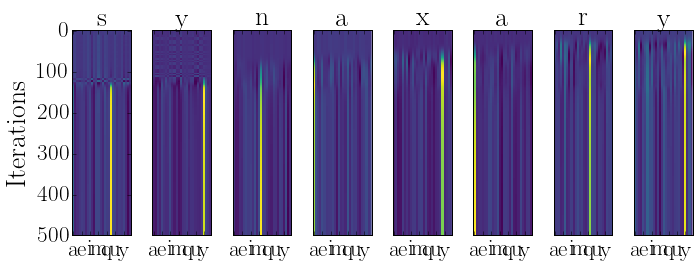

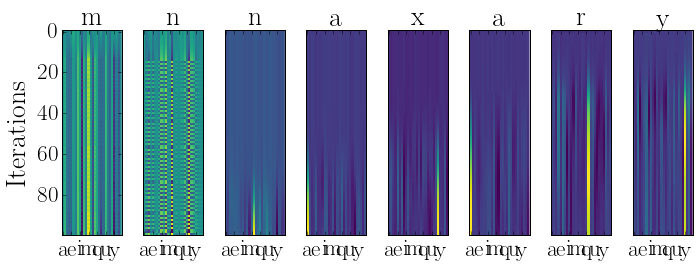

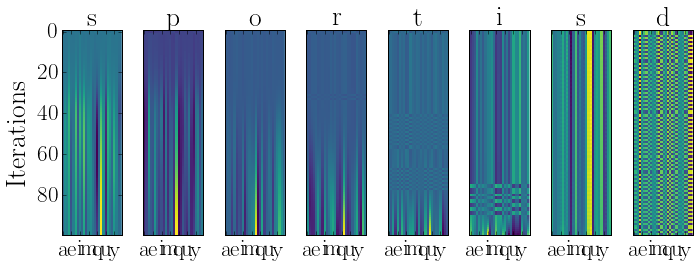

In [12]:

print found
print exs.shape
print convfound
print convexs.shape

pts = np.where(found == 1)[0]
for i in range(0,1):#pts.shape[0]): 
    resplot_im(exs[int(pts[i])],
              'fill_pattern',
              500,
              1000,
              i)

pts = np.where(convfound == 1)[0]
for i in range(pts.shape[0]):
    coef_hists = convexs[int(pts[i])]
    steps = check_convstep(coef_hists)
    conv_coef_hists = [coef_hists[j][:steps] for j in range(len(coef_hists))]
    resplot_im(conv_coef_hists,
               'fill_pattern',
               steps,
               1000,
               i)
